# Overall price 

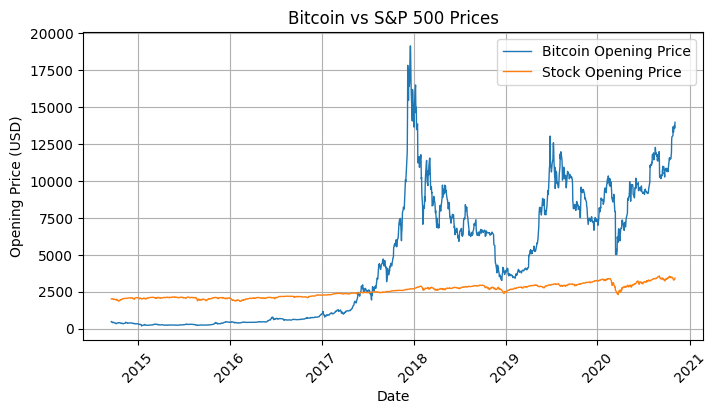

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

prices = pd.read_csv('./Processed/combined_prices.csv')

prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.sort_values('Date')
prices.set_index('Date', inplace=True)


plt.figure(figsize=(8, 4)) 
plt.plot(prices.index, prices['Open_B'], label='Bitcoin Opening Price', linewidth=1)
plt.plot(prices.index, prices['Open_S'], label='Stock Opening Price', linewidth=1)

plt.title('Bitcoin vs S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Opening Price (USD)')

plt.xticks(rotation=45)

plt.grid(True)

plt.legend()  
plt.show()

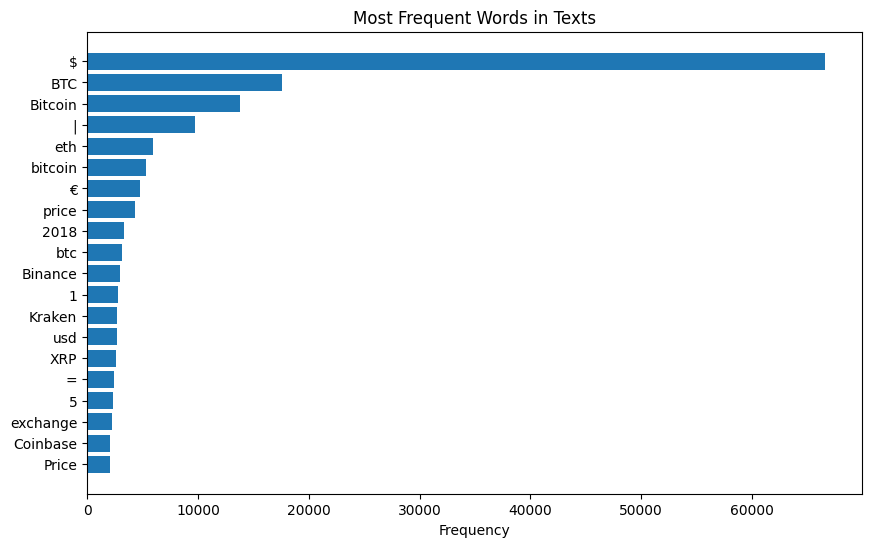

In [13]:
from collections import Counter

visu_words = pd.read_pickle('visu_words.pkl')

word_counter = Counter()

for tokens in visu_words['body']:
    word_counter.update(tokens)

words, counts = zip(*word_counter.most_common(20))

plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1])
plt.xlabel('Frequency')
plt.title('Most Frequent Words in Texts')
plt.show()
